In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
tf.__version__

'2.8.0'

In [2]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [3]:
train_params = np.load('LHS_params_1dim5000_omega_b.npz')                #LHS  

In [4]:
print(train_params.files)                                       # Each of the keys has an 'np.array' of values

['omega_b']


In [5]:
#print(train_params['omega_b'])

n_samples = len(train_params['omega_b'])
print('number of training samples:', len(train_params['omega_b'])) 
print(train_params['omega_b'])

number of training samples: 5000
[0.01952771 0.0204841  0.02027546 ... 0.01916223 0.02155111 0.0209994 ]


In [6]:
cosmo_params = np.zeros((len(train_params['omega_b']), 1))
print(cosmo_params[4999])

cosmo_params[:, 0] = train_params['omega_b']

## Training input params:
omega_b = cosmo_params[:, 0]

[0.]


In [7]:
with open('pk_data_1dim5000_omega_b.pkl', 'rb') as f:
    pk_matrix = pickle.load(f)

In [8]:
omega_b.dtype

dtype('float64')

In [9]:
# Training input params and output param:

train_omega_b = omega_b                               #5000x1                   
train_pk = pk_matrix                           #5000x500                    # don't need kh, stays the same
print("train_pk shape:", np.shape(train_pk))

train_pk shape: (5000, 500)


In [10]:
input_params = np.vstack([train_omega_b])                                        # 1x5000

input_params_transpose = np.transpose(input_params)
print(np.shape(input_params_transpose))
print(np.shape(train_pk))

input_data = pd.DataFrame(input_params_transpose)
input_data.columns = ['Omega_b']

output_data = pd.DataFrame(train_pk)                                       
print(input_data)                                                         #5000x1
#print(output_data)

(5000, 1)
(5000, 500)
       Omega_b
0     0.019528
1     0.020484
2     0.020275
3     0.021293
4     0.021487
...        ...
4995  0.020787
4996  0.018399
4997  0.019162
4998  0.021551
4999  0.020999

[5000 rows x 1 columns]


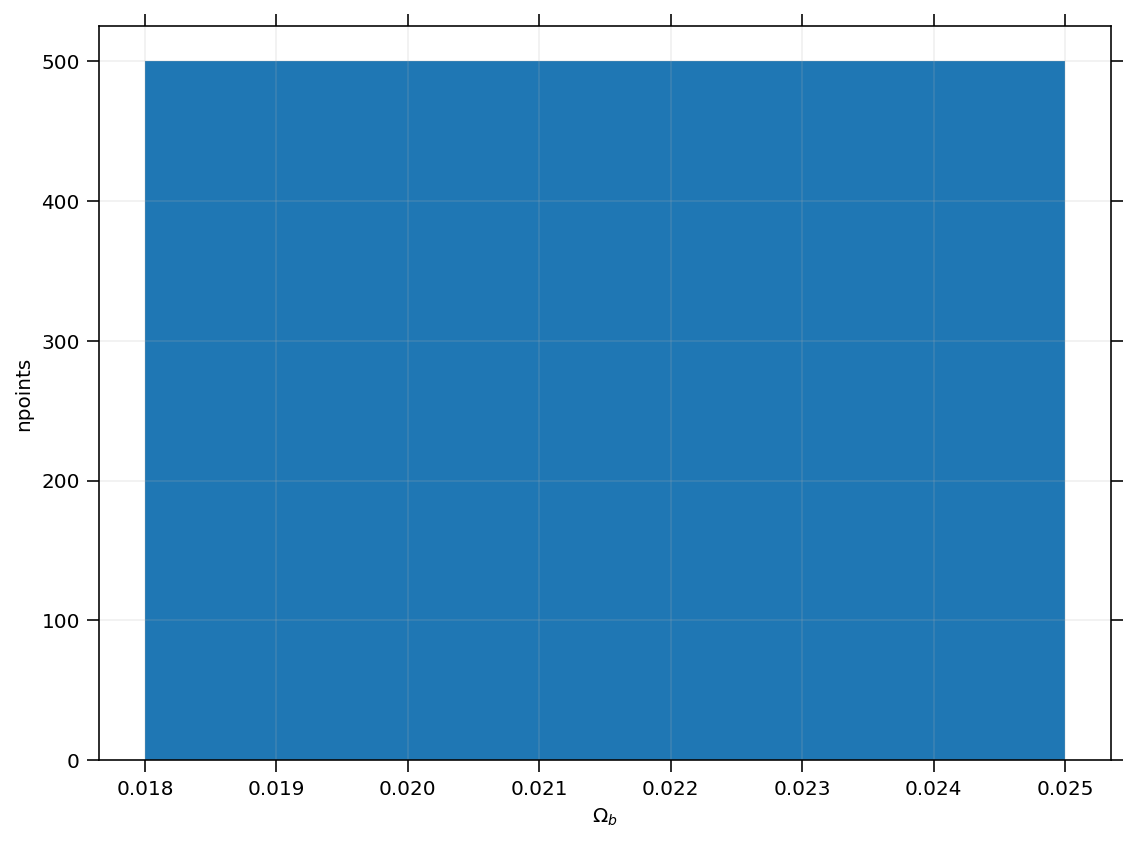

In [11]:
plt.figure(figsize = (8,6))
plt.hist(input_data['Omega_b'])
plt.xlabel(r'$\Omega_{b}$')
plt.ylabel('npoints')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.tight_layout()

In [12]:
# Standardising:

train_input_data = StandardScaler()
test_output_data = StandardScaler()

# Storing the fit object for later reference
scaled_input = train_input_data.fit(input_data.values)               # Compute the mean and std to be used for later scaling

scaled_output = test_output_data.fit(output_data.values)

# Generating the standardized values of input and output:
X = scaled_input.transform(input_data.values)                        # Perform standardisation by centring and scaling    
y = scaled_output.transform(output_data.values)             
print(X)

[[-0.97583744]
 [-0.50264115]
 [-0.60587138]
 ...
 [-1.15666355]
 [ 0.02528794]
 [-0.24768327]]


-1.7317044320414514 2.7522172429686167


(array([500., 500., 500., 500., 500., 500., 500., 500., 500., 500.]),
 array([-1.73170443e+00, -1.38536355e+00, -1.03902266e+00, -6.92681773e-01,
        -3.46340886e-01,  8.88178420e-16,  3.46340886e-01,  6.92681773e-01,
         1.03902266e+00,  1.38536355e+00,  1.73170443e+00]),
 <BarContainer object of 10 artists>)

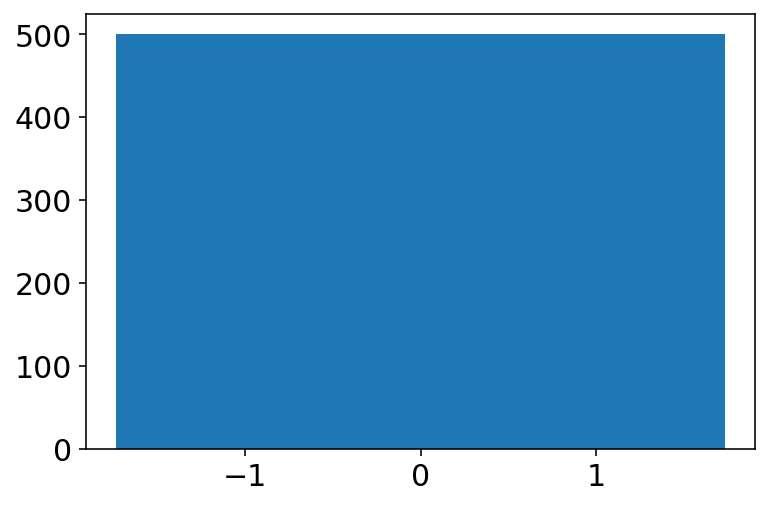

In [13]:
print(X.min(), y.max())
plt.hist(X)

In [14]:
# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.shape(X_train))    # 4000x1
print(X_train.shape[1])     # 1

(4000, 1)
1


In [15]:
print(X_train)

[[-0.69108829]
 [ 1.31185531]
 [ 1.19961841]
 ...
 [-1.28206403]
 [-1.16151329]
 [-0.43890168]]


In [16]:
print("y_test samples, pts:", np.shape(y_test))
print("y_train samples, pts:", np.shape(y_train))
print("X_train samples, pts:", np.shape(X_train))
print("X_test samples, pts:",np.shape(X_test))
#print("X_train:", X_train)
#print("X_test:", X_test)

y_test samples, pts: (1000, 500)
y_train samples, pts: (4000, 500)
X_train samples, pts: (4000, 1)
X_test samples, pts: (1000, 1)


In [17]:
%%time
#Building the NN:

tf_model = Sequential()
# Defining the input layer of the model
tf_model.add(Dense(units=250, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')) # 
 
# Defining 1st Hidden layer of the model
tf_model.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining 2nd Hidden layer of the model
tf_model.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining the 3rd hidden layer of the model
#tf_model.add(Dense(units=150, kernel_initializer='normal', activation='relu'))  

# Defining the 4th hidden layer of the model
#tf_model.add(Dense(units=150, kernel_initializer='normal', activation='relu')) 

#Defining the output layer of the model
tf_model.add(Dense(500, kernel_initializer='normal'))
 
opt = keras.optimizers.Adam(learning_rate=1e-4)
    
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer=opt)
 
# Fitting the ANN to the Training set
hist_ = tf_model.fit(X_train, y_train, batch_size = 50, epochs = 250, validation_split=0.2, verbose=1)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#98.68772968649124, l_rate = 1e-4, 250 epochs
tf_model.summary()

Epoch 1/250
64/64 [==============================] - 1s 5ms/step - loss: 0.9748 - val_loss: 0.8736
Epoch 2/250
64/64 [==============================] - 0s 3ms/step - loss: 0.5768 - val_loss: 0.1635
Epoch 3/250
64/64 [==============================] - 0s 3ms/step - loss: 0.0661 - val_loss: 0.0295
Epoch 4/250
64/64 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0228
Epoch 5/250
64/64 [==============================] - 0s 3ms/step - loss: 0.0234 - val_loss: 0.0202
Epoch 6/250
64/64 [==============================] - 0s 3ms/step - loss: 0.0206 - val_loss: 0.0177
Epoch 7/250
64/64 [==============================] - 0s 3ms/step - loss: 0.0179 - val_loss: 0.0152
Epoch 8/250
64/64 [==============================] - 0s 3ms/step - loss: 0.0154 - val_loss: 0.0129
Epoch 9/250
64/64 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0100
Epoch 10/250
64/64 [==============================] - 0s 4ms/step - loss: 0.0091 - val_loss: 0.0066
Epoch 11/

64/64 [==============================] - 0s 2ms/step - loss: 6.1742e-05 - val_loss: 5.6128e-05
Epoch 79/250
64/64 [==============================] - 0s 3ms/step - loss: 6.1152e-05 - val_loss: 5.6561e-05
Epoch 80/250
64/64 [==============================] - 0s 3ms/step - loss: 6.0880e-05 - val_loss: 5.4832e-05
Epoch 81/250
64/64 [==============================] - 0s 3ms/step - loss: 6.0384e-05 - val_loss: 5.4907e-05
Epoch 82/250
64/64 [==============================] - 0s 3ms/step - loss: 6.0112e-05 - val_loss: 5.4374e-05
Epoch 83/250
64/64 [==============================] - 0s 3ms/step - loss: 5.9669e-05 - val_loss: 5.4183e-05
Epoch 84/250
64/64 [==============================] - 0s 3ms/step - loss: 5.9424e-05 - val_loss: 5.3684e-05
Epoch 85/250
64/64 [==============================] - 0s 2ms/step - loss: 5.8569e-05 - val_loss: 5.5760e-05
Epoch 86/250
64/64 [==============================] - 0s 3ms/step - loss: 5.9295e-05 - val_loss: 5.4618e-05
Epoch 87/250
64/64 [=====================

64/64 [==============================] - 0s 3ms/step - loss: 4.4358e-05 - val_loss: 3.9015e-05
Epoch 154/250
64/64 [==============================] - 0s 3ms/step - loss: 4.3803e-05 - val_loss: 3.8534e-05
Epoch 155/250
64/64 [==============================] - 0s 3ms/step - loss: 4.4877e-05 - val_loss: 3.9032e-05
Epoch 156/250
64/64 [==============================] - 0s 3ms/step - loss: 4.3102e-05 - val_loss: 4.1651e-05
Epoch 157/250
64/64 [==============================] - 0s 3ms/step - loss: 4.3287e-05 - val_loss: 3.8231e-05
Epoch 158/250
64/64 [==============================] - 0s 3ms/step - loss: 4.3884e-05 - val_loss: 4.0908e-05
Epoch 159/250
64/64 [==============================] - 0s 3ms/step - loss: 4.5323e-05 - val_loss: 3.9870e-05
Epoch 160/250
64/64 [==============================] - 0s 3ms/step - loss: 4.3081e-05 - val_loss: 3.9311e-05
Epoch 161/250
64/64 [==============================] - 0s 3ms/step - loss: 4.3676e-05 - val_loss: 3.9204e-05
Epoch 162/250
64/64 [============

64/64 [==============================] - 0s 4ms/step - loss: 3.8967e-05 - val_loss: 3.3073e-05
Epoch 229/250
64/64 [==============================] - 0s 3ms/step - loss: 3.5830e-05 - val_loss: 3.1364e-05
Epoch 230/250
64/64 [==============================] - 0s 3ms/step - loss: 3.5056e-05 - val_loss: 3.0888e-05
Epoch 231/250
64/64 [==============================] - 0s 3ms/step - loss: 3.5146e-05 - val_loss: 3.0744e-05
Epoch 232/250
64/64 [==============================] - 0s 3ms/step - loss: 3.5111e-05 - val_loss: 3.1847e-05
Epoch 233/250
64/64 [==============================] - 0s 3ms/step - loss: 3.5914e-05 - val_loss: 3.1838e-05
Epoch 234/250
64/64 [==============================] - 0s 3ms/step - loss: 3.5636e-05 - val_loss: 3.1281e-05
Epoch 235/250
64/64 [==============================] - 0s 3ms/step - loss: 3.5432e-05 - val_loss: 3.2118e-05
Epoch 236/250
64/64 [==============================] - 0s 3ms/step - loss: 3.5550e-05 - val_loss: 3.4289e-05
Epoch 237/250
64/64 [============

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

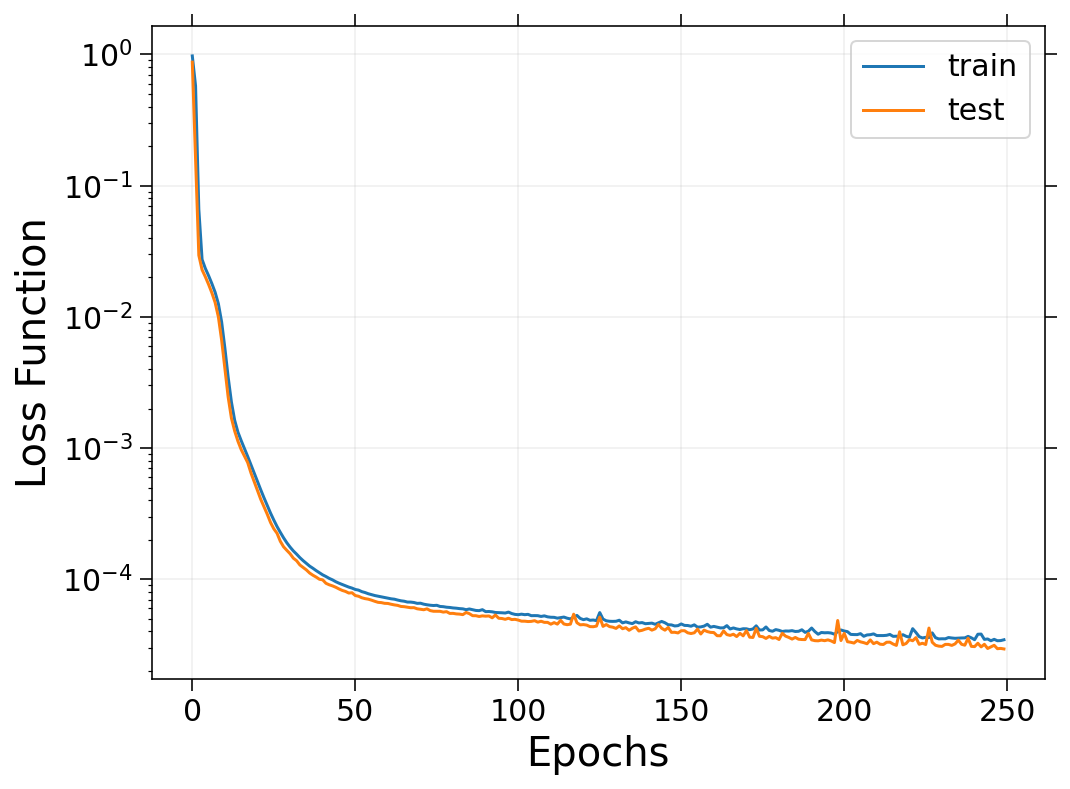

In [21]:
plt.figure(figsize = (8,6))
plt.plot(hist_.history["loss"], label="train")
plt.plot(hist_.history["val_loss"], label="test")
plt.legend(fontsize=15)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.savefig('Loss_Func_Omega_b.jpg')
plt.tight_layout

Omega_b: 0.0180 - 0.02500.02242


parameter:  ['0.02242']
user_list: [0.02242]
cosmo_arr [[0.02242]]
cosmo_arr[0] [0.02242]
input_scaled [[0.45519088]]
H0: 0.02242


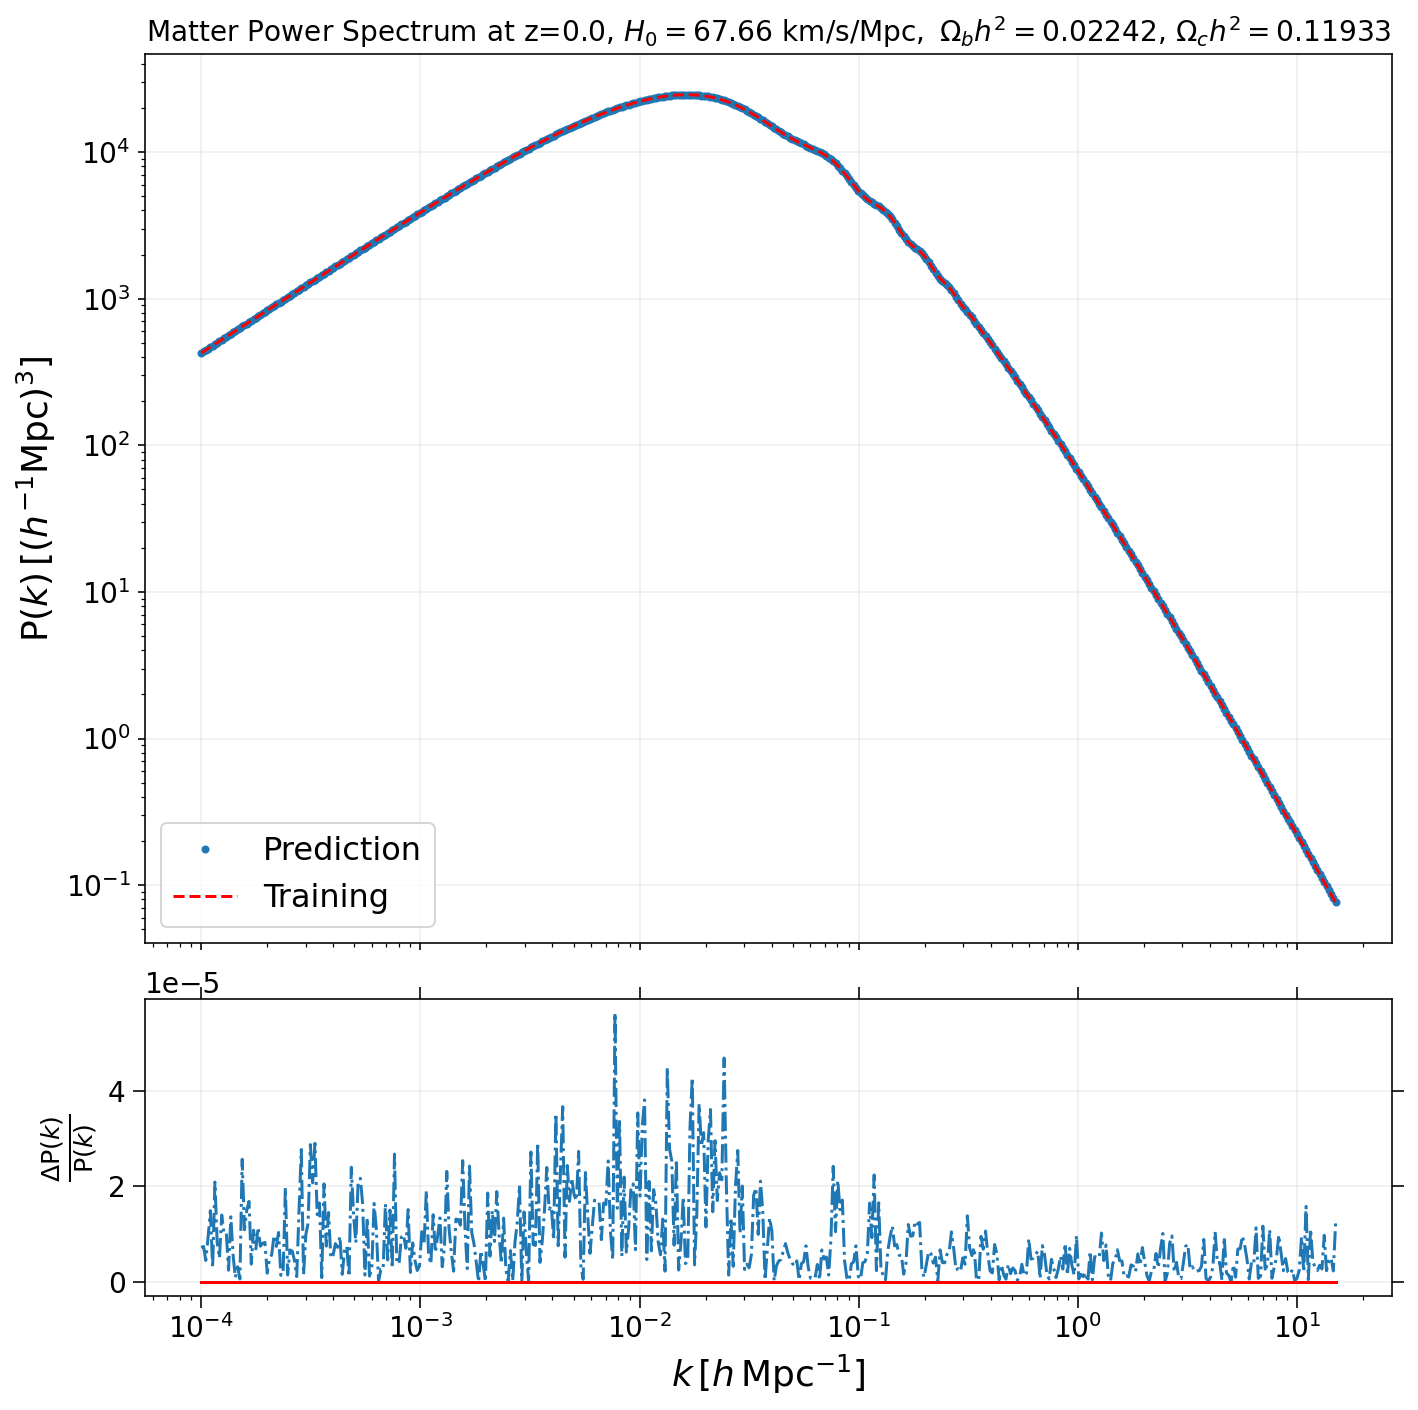

In [31]:
#Define func:

def calc_cosmo():
    input_cosmo_val = input('Omega_b: 0.0180 - 0.0250')
    print("\n")
    user_list = input_cosmo_val.split()
    # print list
    print('parameter: ', user_list)

    # convert each item to float type
    for i in range(len(user_list)):
        # convert each item to float type
        user_list[i] = float(user_list[i])
    print("user_list:", user_list)
        
    
    cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
    print('cosmo_arr', cosmo_arr)
    print('cosmo_arr[0]', cosmo_arr[0])
    scaled = train_input_data.fit(input_data.values)
    input_scaled = scaled.transform(cosmo_arr)
    print('input_scaled', input_scaled)
    
    pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))
    
    
    #Compute P.S via CAMB:
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.66, ombh2=cosmo_arr[0][0], omch2=0.11933)
    pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
    pars.set_matter_power(redshifts=[0.0], kmax=15.0)
    pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
    s8_current = np.array(results.get_sigma8())
    s8_fid = np.array([0.8102])
    renorm_s8 = (s8_fid/s8_current)**2
    camb_pk = renorm_s8*camb_pk_cur


    print('H0:' , cosmo_arr[0][0])
    #print(pred_pk)
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize = (10,10), gridspec_kw={'height_ratios': [3, 1]})                                            
    ax[0].loglog(camb_kh, pred_pk[0], "C0.")                                                                                     
    ax[0].loglog(camb_kh, camb_pk[0], 'r', linestyle='dashed')                                                                 
    ax[0].set_title('Matter Power Spectrum at z=0.0, $H_{0} = 67.66\ \mathregular{km/s/Mpc},$ '+ '$\Omega_{b}h^{2} = %0.7s$, '%cosmo_arr[0][0] + '$\Omega_{c}h^{2} = 0.11933$', fontsize = 14)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(['Prediction', 'Training'], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)
    
    #residual plot 
    ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
    ax[1].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0]), 'C0', linestyle="dashdot") 
    ax[1].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]), 'r')
    ax[1].set_yscale('linear')
    #ax[1].set_ylim(0, 0.05)
    fig.tight_layout()
    plt.savefig('NN_MPS_Omega_b.jpg')
    plt.show()
    

Generate = calc_cosmo()



parameter:  0.018
user_list: 0.018
cosmo_arr [[0.018]]
cosmo_arr[0] [0.018]
input_scaled [[-1.73170443]]
Omega_b: 0.018


parameter:  0.019
user_list: 0.019
cosmo_arr [[0.019]]
cosmo_arr[0] [0.019]
input_scaled [[-1.23693174]]
Omega_b: 0.019


parameter:  0.02
user_list: 0.02
cosmo_arr [[0.02]]
cosmo_arr[0] [0.02]
input_scaled [[-0.74215904]]
Omega_b: 0.02


parameter:  0.021
user_list: 0.021
cosmo_arr [[0.021]]
cosmo_arr[0] [0.021]
input_scaled [[-0.24738635]]
Omega_b: 0.021


parameter:  0.022
user_list: 0.022
cosmo_arr [[0.022]]
cosmo_arr[0] [0.022]
input_scaled [[0.24738635]]
Omega_b: 0.022


parameter:  0.023
user_list: 0.023
cosmo_arr [[0.023]]
cosmo_arr[0] [0.023]
input_scaled [[0.74215904]]
Omega_b: 0.023


parameter:  0.024
user_list: 0.024
cosmo_arr [[0.024]]
cosmo_arr[0] [0.024]
input_scaled [[1.23693174]]
Omega_b: 0.024


parameter:  0.025
user_list: 0.025
cosmo_arr [[0.025]]
cosmo_arr[0] [0.025]
input_scaled [[1.73170443]]
Omega_b: 0.025


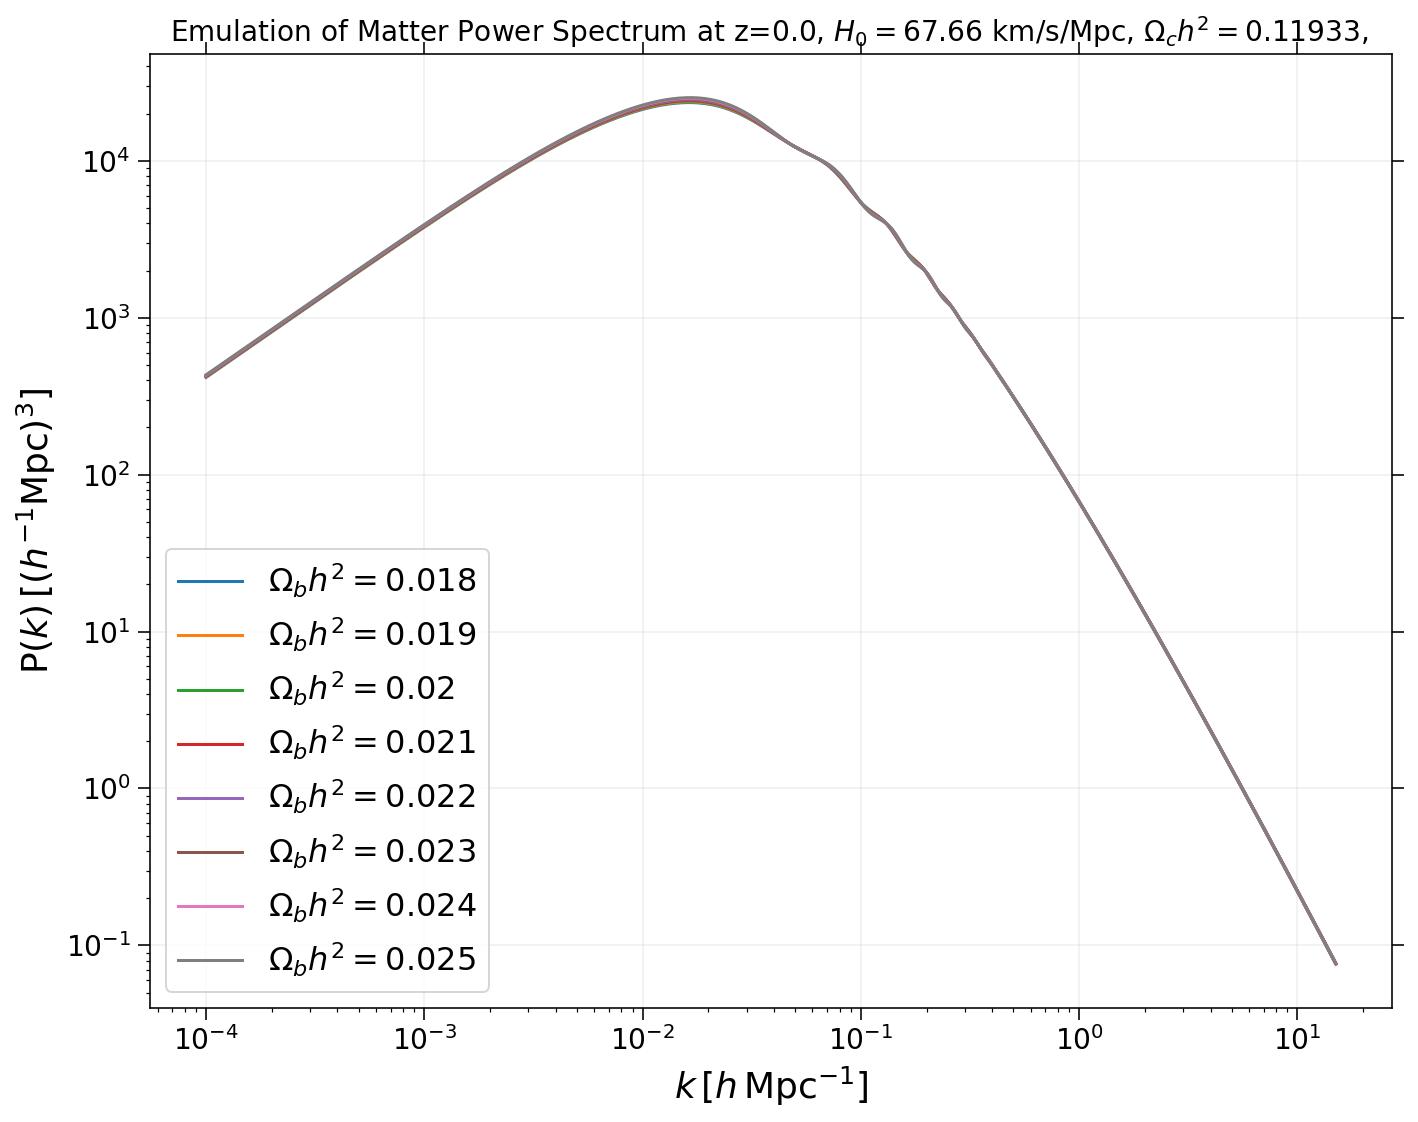

In [29]:
#Define func:
def calc_cosmo():
    plt.figure(figsize = (10,8))
    ombh2_input = np.linspace(0.0180, 0.0250, 8)
    for w in ombh2_input:
        
        print("\n")
        user_list = float(w)
        # print list
        print('parameter: ', user_list)

        # convert each item to float type
        print("user_list:", user_list)
        
    
        cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
        print('cosmo_arr', cosmo_arr)
        print('cosmo_arr[0]', cosmo_arr[0])
        scaled = train_input_data.fit(input_data.values)
        input_scaled = scaled.transform(cosmo_arr)
        print('input_scaled', input_scaled)

        pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))
        #Return to log scale for pred:
        #pred_pk = np.exp(pred_rescaled_pk)
    
    
        #Compute P.S via CAMB:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=67.66, ombh2=cosmo_arr[0][0], omch2=0.11933)
        pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
        pars.set_matter_power(redshifts=[0.0], kmax=15.0)
        pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

        # Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
        s8_current = np.array(results.get_sigma8())
        s8_fid = np.array([0.8102])
        renorm_s8 = (s8_fid/s8_current)**2
        camb_pk = renorm_s8*camb_pk_cur


        print('Omega_b:' , cosmo_arr[0][0])
        
                                             
        plt.loglog(camb_kh, pred_pk[0])                                                          # prediction                            
        #plt.loglog(camb_kh, camb_pk[0], 'r' , linestyle='dashed')                               # CAMB                          
    plt.title('Emulation of Matter Power Spectrum at z=0.0, ' + '$H_{0} = 67.66\ \mathregular{km/s/Mpc}$, ' + '$\Omega_{c}h^{2} = 0.11933$, ', fontsize = 14)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    plt.legend(["$\Omega_{b}h^{2} = %0.6s$"%w for w in  ombh2_input], loc='lower left', fontsize=16);
    plt.grid(alpha=0.2)
    plt.grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)

    plt.tight_layout()
#   #plt.savefig('power_spectrum_H0.pdf')
    plt.show()
    

Generate = calc_cosmo()



parameter:  0.018
user_list: 0.018
cosmo_arr [[0.018]]
cosmo_arr[0] [0.018]
input_scaled [[-1.73170443]]
Omega_b: 0.018


parameter:  0.019
user_list: 0.019
cosmo_arr [[0.019]]
cosmo_arr[0] [0.019]
input_scaled [[-1.23693174]]
Omega_b: 0.019


parameter:  0.02
user_list: 0.02
cosmo_arr [[0.02]]
cosmo_arr[0] [0.02]
input_scaled [[-0.74215904]]
Omega_b: 0.02


parameter:  0.021
user_list: 0.021
cosmo_arr [[0.021]]
cosmo_arr[0] [0.021]
input_scaled [[-0.24738635]]
Omega_b: 0.021


parameter:  0.022
user_list: 0.022
cosmo_arr [[0.022]]
cosmo_arr[0] [0.022]
input_scaled [[0.24738635]]
Omega_b: 0.022


parameter:  0.023
user_list: 0.023
cosmo_arr [[0.023]]
cosmo_arr[0] [0.023]
input_scaled [[0.74215904]]
Omega_b: 0.023


parameter:  0.024
user_list: 0.024
cosmo_arr [[0.024]]
cosmo_arr[0] [0.024]
input_scaled [[1.23693174]]
Omega_b: 0.024


parameter:  0.025
user_list: 0.025
cosmo_arr [[0.025]]
cosmo_arr[0] [0.025]
input_scaled [[1.73170443]]
Omega_b: 0.025


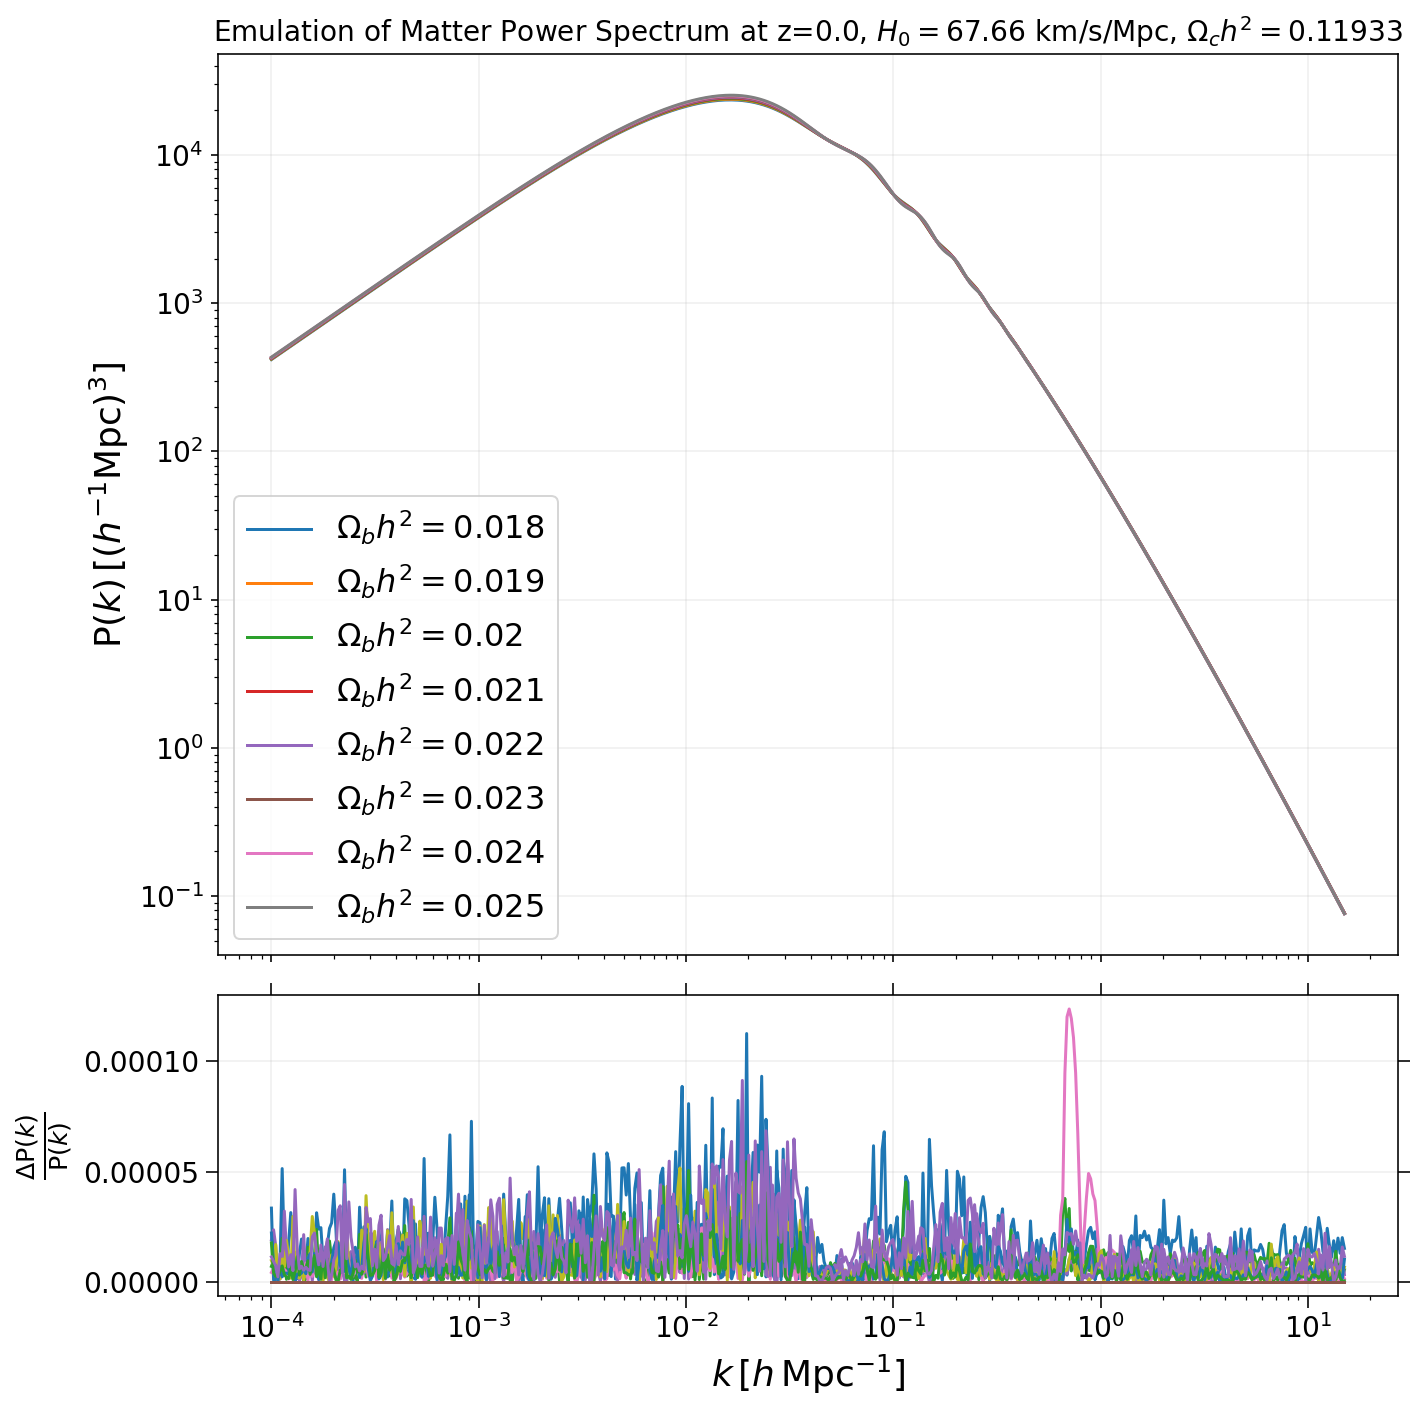

In [33]:
#Define func:

def calc_cosmo():
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize = (10,10), gridspec_kw={'height_ratios': [3, 1]})
    ombh2_input = np.linspace(0.0180, 0.0250, 8)
    for w in ombh2_input:
        
        print("\n")
        user_list = float(w)
        # print list
        print('parameter: ', user_list)

        # convert each item to float type
        print("user_list:", user_list)
        
    
        cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
        print('cosmo_arr', cosmo_arr)
        print('cosmo_arr[0]', cosmo_arr[0])
        scaled = train_input_data.fit(input_data.values)
        input_scaled = scaled.transform(cosmo_arr)
        print('input_scaled', input_scaled)

        pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))
    
    
        #Compute P.S via CAMB:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=67.66, ombh2=cosmo_arr[0][0], omch2=0.11933)
        pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
        pars.set_matter_power(redshifts=[0.0], kmax=15.0)
        pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

        # Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
        s8_current = np.array(results.get_sigma8())
        s8_fid = np.array([0.8102])
        renorm_s8 = (s8_fid/s8_current)**2
        camb_pk = renorm_s8*camb_pk_cur


        print('Omega_b:' , cosmo_arr[0][0])
        
                                             
        ax[0].loglog(camb_kh, pred_pk[0])                                                    # prediction                            
        #ax[0].loglog(camb_kh, camb_pk[0])                                                   # CAMB
        
        #residual plot 
        ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
        ax[1].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0])) 
        ax[1].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]))
        ax[1].set_yscale('linear')
        #ax[1].set_ylim(0, 0.05)
        
    ax[0].set_title('Emulation of Matter Power Spectrum at z=0.0, ' + '$H_{0} = 67.66\ \mathregular{km/s/Mpc}$, ' + '$\Omega_{c}h^{2} = 0.11933$', fontsize = 14)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(["$\Omega_{b}h^{2} = %0.6s$"%w for w in  ombh2_input], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)


        
    fig.tight_layout()
    plt.savefig('NN_MPS_Omega_b_range.jpg')
    plt.show()
    

Generate = calc_cosmo()